In [1]:
import nibabel as nib
import os
import numpy as np
import os.path as op
import scipy
import pandas as pd
import pickle
import scipy.stats
from ipyparallel import Client
from statsmodels.formula.api import ols
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from sklearn import manifold
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/home/iballard/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
rc = Client()

In [ ]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [4]:
def compute_inv_shrunk_covariance(x,mask):
    #see http://www.diedrichsenlab.org/pubs/Walther_Neuroimage_2016.pdf
    t,n = x.shape #t measurements by n voxels

    #demean
    x = x - x.mean(0)

    #compute covariance
    sample = (1.0/t) * np.dot(np.transpose(x),x)

    #copute prior
    prior = np.diag(np.diag(sample))

    #deal with occasional empty voxel by avoiding singularity
    for i in range(prior.shape[0]):
        if prior[i,i] < 1e-6:
            prior[i,i] = 1e-6
            
    #compute shrinkage
    d = 1.0/n * np.linalg.norm(sample - prior,ord = 'fro')**2
    y = np.square(x)
    r2 = 1.0/n/t**2 * np.sum(np.sum(np.dot(np.transpose(y),y)))- \
    1.0/n/t*np.sum(np.sum(np.square(sample)))

    #compute the estimator
    shrinkage = max(0,min(1,r2/d))
    sigma = shrinkage*prior + (1-shrinkage)*sample

    #compute the inverse
    try:
        inv_sigma = np.linalg.inv(sigma)
    except:
        inv_sigma = np.linalg.inv(prior) #univariate

    
    return inv_sigma

In [5]:
#project a onto be
def vector_reject(a,b): #a gives variance to be
    return a - (np.dot(a,b)/np.dot(b,b)) * b    

In [6]:
#make sure MTL masks are exclusive
def trim_mask(sub,mask,m):
    exclusions = overlap_masks[:]
    exclusions.remove(m)

    m1 = op.join(home_dir,'data', sub,  'masks', exclusions[0] +'.nii.gz')
    m1 = nib.load(m1).get_data().astype(bool)

    m2 = op.join(home_dir,'data', sub,  'masks', exclusions[1] +'.nii.gz')
    m2 = nib.load(m2).get_data().astype(bool)

    bad = np.logical_or(m1,m1)
    good = np.invert(bad)

    mask = np.logical_and(mask,good)
    return mask

In [7]:
def compute_inverse_sigma(sub,exp,smooth,masks):
    sub_path = op.join(home_dir,'analysis', exp, sub, 'reg','epi', smooth)
    for run in map(str,range(1,4)):
        res = op.join(sub_path, 'run_'  + run,'res4d_xfm.nii.gz')

        if op.exists(res):
            res = nib.load(res).get_data().astype(float)

            for m in masks:
                out_f = op.join(home_dir,'covariance','_'.join([exp,sub,smooth,run,m]) + '.txt')
                if not op.exists(out_f): #don't recompute
                    mask = op.join(home_dir,'data', sub,  'masks', m + '.nii.gz')
                    mask = nib.load(mask).get_data().astype(bool)
                    if m in overlap_masks:
                        mask = trim_mask(sub,mask,m)

                    x = res[mask]
                    x = np.transpose(x)

                    inv_sigma = compute_inv_shrunk_covariance(x,m)

                    inv_sigma = scipy.linalg.fractional_matrix_power(inv_sigma,.5) #take square root

                    np.savetxt(out_f,inv_sigma)


In [8]:
def delete_inverse_sigma(sub,exp,smooth,masks):
    for run in map(str,range(1,4)):
        for m in masks:
            out_f = op.join(home_dir,'covariance','_'.join([exp,sub,run,m]) + '.txt')
            if op.exists(out_f):
                os.remove(out_f)

In [9]:
def get_condition(i,single):
    if single:
        return cond_map[i], 1
    elif i < 11:
        cond = 'b_plus'
        trial = i
    elif i < 21:
        cond = 'c_plus'
        trial = i - 10
    elif i < 31:
        cond = 'c_minus'
        trial = i - 20
    elif i < 41:
        cond = 'b_minus'
        trial = i - 30
    return cond,trial

In [10]:
def extract_betas(sub,exp,smooth,masks,single = True):
    if single:
        nbetas = 4
    else:
        nbetas = 40
        exp_id = 'sim_4mm-betas'
            
    all_betas = []
    for m in masks:
        out_f = op.join(home_dir,'betas', '_'.join([exp_id,sub,smooth,m]) + '.csv')
        
        #extract saved betas
        if not op.exists(out_f):
            betas = {'sub':[],'mask':[],'run':[],'condition':[],'value':[],'trial':[],'voxel':[],'row':[]}
            sub_path = op.join(home_dir,'analysis', exp_id, sub, 'reg','epi', smooth )

            mask = op.join(home_dir,'data', sub,  'masks', m + '.nii.gz')
            mask = nib.load(mask).get_data().astype(bool)
            if m in overlap_masks:
                mask = trim_mask(sub,mask,m)


            for run in map(str,range(1,4)):
                run_dir = op.join(sub_path, 'run_'  + run)

                if os.path.exists(run_dir):

                    for i in range(1,nbetas + 1):
                        f = run_dir + '/cope' + str(i) + '_xfm.nii.gz'

                        cond, trial = get_condition(i,single)

                        #load stat image
                        stat = nib.load(f).get_data().astype(float)
                        stat = stat[mask]

                        for n,val in enumerate(stat):
                            betas['voxel'].append(n)                        
                            betas['sub'].append(sub)
                            betas['value'].append(val)
                            betas['mask'].append(m)
                            betas['run'].append(int(run))
                            betas['condition'].append(cond)
                            betas['trial'].append(trial)
                            betas['row'].append(i)
                else:
                    print run_dir

            betas = pd.DataFrame(betas)
            betas.to_csv(out_f,index = False)
            
        else: #load from disk
            betas = pd.read_csv(out_f)
            
        all_betas.append(betas)
    all_betas = pd.concat(all_betas)
    all_betas = all_betas.set_index(['sub', 'run','mask','condition','trial'])
    return all_betas

In [11]:
def prewhiten_betas(old_betas,sub,exp,smooth,masks,single = True):
    
    all_betas = []
    if not single:
        exp_id = 'sim_4mm-betas'
        
    for m in masks:
        out_f = op.join(home_dir,'betas', 'whitened','_'.join([exp_id,sub,smooth,m]) + '.csv')
        if op.exists(out_f):
            all_betas.append(pd.read_csv(out_f))
            
        else:
            betas = old_betas.xs(m, level='mask', axis=0)
            
            for run in map(str,range(1,4)):
                #load covariance
                inv_sigma = op.join(home_dir,'covariance','_'.join([exp,sub,smooth,run,m]) + '.txt')
                if op.exists(inv_sigma):
                    inv_sigma = np.loadtxt(inv_sigma)

                    for cond in conds:
                        for trial in range(1,11):
                            vals = betas.loc[(sub,int(run),cond,trial),'value'].values
                            try:
                                whiten_vals = np.dot(inv_sigma,vals)
                                betas.loc[(sub,int(run),cond,trial),'value'] = whiten_vals
                            except:
                                return (m,sub,run)
                else:
                    print 'no covariance file',inv_sigma
                    
            out_betas = pd.DataFrame(betas.to_records()) 
            out_betas['mask'] = m
            out_betas.to_csv(out_f,index = False)
            all_betas.append(out_betas)
        
    all_betas = pd.concat(all_betas)
    all_betas = all_betas.set_index(['sub', 'run','mask','condition','trial'])
    return all_betas

In [12]:
def compute_rsa_betas(sub,exp,masks,betas):
    rsa_df = {'cond1':[],'cond2':[],'corr':[],'mask':[],'run':[],'sub':[]}
    runs = list(set(map(lambda x: x[0],betas.loc[(sub)].index))) #get runs
    
    for m in masks:
        
        for i in range(1,nconds+1):
            for j in range(1,nconds+1):
                
                if i<= j:
                    for trial1 in range(1,11):
                        for trial2 in range(1,11):

                            if i !=j or trial1 < trial2:
                                for run in runs:
                                    b1 = betas.loc[(sub,run,m,cond_map[i],trial1),'value'].values
                                    b2 = betas.loc[(sub,run,m,cond_map[j],trial2),'value'].values

                                    distance = scipy.stats.pearsonr(b1,b2)[0]

                                    rsa_df['mask'].append(m)
                                    rsa_df['sub'].append(sub)
                                    rsa_df['cond1'].append(name_map[cond_map[i]] + str(trial1-1))
                                    rsa_df['cond2'].append(name_map[cond_map[j]] + str(trial2-1))
                                    rsa_df['corr'].append(distance)        
                                    rsa_df['run'].append(run)        
    return pd.DataFrame(rsa_df)


In [13]:
def run_sub(sub):
    out_f = op.join(home_dir,'rsa', sub + 'rsa_sim_OFC.pkl')

    if not op.exists(out_f):

        compute_inverse_sigma(sub,exp,smooth,masks)
        betas = extract_betas(sub,exp,smooth,masks,False)
        betas = prewhiten_betas(betas,sub,exp,smooth,masks,False)
        delete_inverse_sigma(sub,exp,smooth,masks) #save disk space

#         #calculate RSA
        rsas = compute_rsa_betas(sub,exp,masks,betas)

        #write rsa to a file in case we have to stop the script
        output = open(out_f, 'wb')
        pickle.dump(rsas, output)
        output.close()

In [14]:
from itertools import chain
overlap_masks = ['para_sim','peri_sim','hipp']

exp = 'sim_4mm-betas'
smooth = 'smoothed'
conds = ['b_plus','b_minus','c_plus','c_minus']
name_map = { 'b_plus':'AB+_', 'c_minus':'AC-_','b_minus':'B-_','c_plus':'C+_'}
cond_map = {1:'b_plus',2:'c_minus',3:'b_minus',4:'c_plus'}
nconds = len(cond_map.keys())

masks = ['mOFC_fill_sim','yeo17_ifs','hipp','peri_sim','para_sim']

In [41]:
dview = rc[0:12]
dview.block = True

dview.push(dict(home_dir=home_dir,
                masks = masks,
                exp = exp,
                conds = conds,
                smooth = smooth,
                cond_map = cond_map,
                name_map = name_map,
                nconds = nconds,
                get_condition = get_condition,
                overlap_masks = overlap_masks,
                prewhiten_betas = prewhiten_betas,
                compute_inv_shrunk_covariance = compute_inv_shrunk_covariance,
                compute_inverse_sigma = compute_inverse_sigma,
                extract_betas = extract_betas,
                delete_inverse_sigma = delete_inverse_sigma,
                trim_mask = trim_mask,
                compute_rsa_betas = compute_rsa_betas
                ))
dview.execute("import numpy as np")
dview.execute("import os.path as op")
dview.execute("import nibabel as nib")
dview.execute("import pandas as pd")
with dview.sync_imports():
    import os
    import numpy
    import scipy
    import scipy.stats
    import pickle
    
dview.map_sync(run_sub,subs)

# Load and visualize RSA data

In [69]:
# #load RSAs from disk
# all_rsas = []
# for sub in subs:
#     out_f = op.join(home_dir,'rsa', sub + 'rsa_sim_OFC.pkl')
#     rsa = pd.read_pickle(out_f)
#     all_rsas.append(rsa)
# all_rsas = pd.concat(all_rsas)
# fig_rsas = pd.read_csv('/home/iballard/Dropbox/fd/rsa.csv')
all_rsas = pd.read_csv(home_dir + 'rsa_FINAL.csv')

In [73]:
all_rsas = all_rsas[all_rsas['mask'] !='V1']

In [26]:
out_f = op.join(home_dir,'rsa', sub + 'rsa_sim_OFC.csv')
pd.concat([ifs,ofc[ofc['mask'] == 'mOFC_fill_sim']]).to_csv(out_f, index = False)

In [17]:
#add in diagonal elements
new_df = pd.DataFrame()
for sub in subs:
    runs = set(all_rsas.loc[all_rsas['sub'] == sub,'run'])
    for m in masks:
        for run in runs:
            for cond in ['AB+_','B-_','AC-_','C+_']:
                for i in range(10):
                    row = pd.DataFrame({'mask':m,
                                       'sub':sub,
                                        'run':run,
                                        'cond1':cond + str(i),
                                        'cond2':cond + str(i),
                                        'corr': 1.0}, index = [0])
                    new_df = new_df.append(row)
fig_rsas = pd.concat([all_rsas, new_df])

In [20]:
fig_rsas.to_csv('/home/iballard/Dropbox/fd/rsa.csv',index = False)

In [18]:
fig_rsas = fig_rsas.set_index(['mask','run','sub'])

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  # Remove the CWD from sys.path while we load stuff.
/home/iballard/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


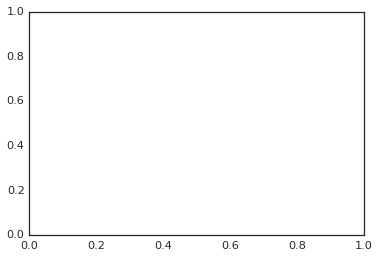

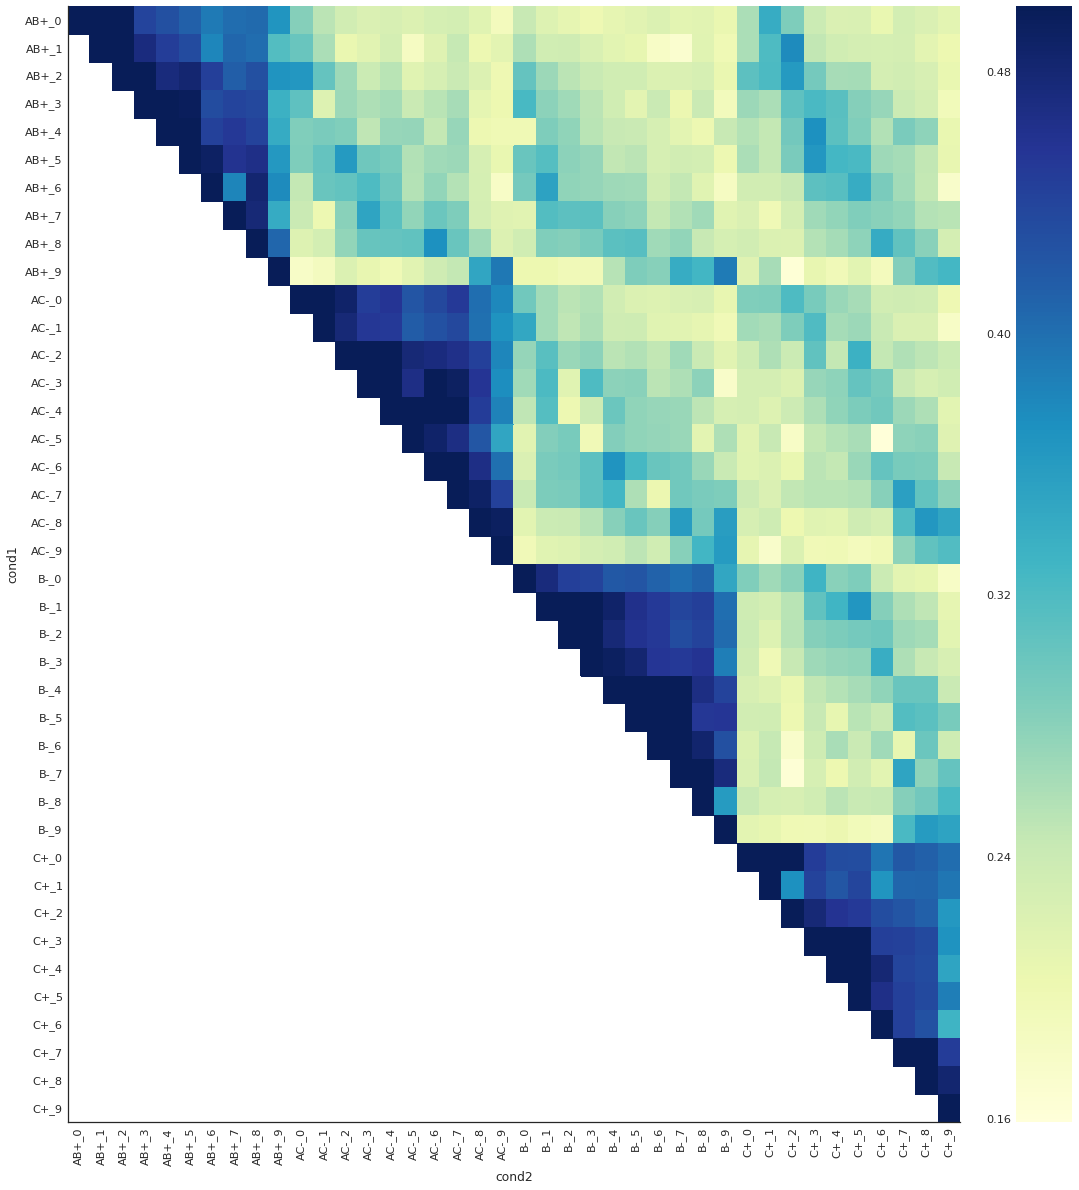

In [22]:
roi = 'hipp'
run = 2
plt.title('')
sns.set_context('paper',font_scale = 1.4)
sns.set_style("white")

fig, ax = plt.subplots()
fig.set_size_inches(20, 20)

mean_rsa = fig_rsas.loc[roi,run].groupby(['cond1','cond2']).mean()
mean_rsa = mean_rsa.unstack()['corr']
sns.heatmap(mean_rsa, vmax = .5, ax = ax,cmap="YlGnBu")
sns.despine()

plt.savefig('/home/iballard/Dropbox/fd/figs/committee_meeting/' + roi + '.svg',dpi = 600)

# Load results of RL modeling

In [4]:
RL_next = pd.read_csv('/home/iballard/fdPE_V_nexttrial.csv')
RL_next = RL_next[RL_next['condition'] != 'feedback']
RL_next = RL_next.set_index(['exp','sub','run','condition'])
RL_next = RL_next.loc[('sim','fd_104')]

RL_std = pd.read_csv('/home/iballard/fdPE_V_trial.csv')
RL_std = RL_std[RL_std['condition'] != 'feedback']
RL_std = RL_std.set_index(['exp','sub','run','condition'])
RL_std = RL_std.loc[('sim','fd_104')]

for i in range(1,4):
    RL_std.loc[i,'trial'] = range(0,40)

# Conduct RSA Analysis

In [78]:
def get_base_model(sub,mask): 
    reverse_name_map = {'AB+':'b_plus','B-':'b_minus','AC-':'c_minus','C+':'c_plus'}

    overlap_pairs = [['b_plus','b_minus'],
                    ['c_plus','c_minus'],
                    ['b_plus','c_minus']]
    overlap_pairs = [set(x) for x in overlap_pairs] #so order doesnt matter
    not_overlap_pairs = [['c_plus','b_minus'],
                         ['b_plus','c_plus'],
                      ['c_minus','b_minus']]
    not_overlap_pairs = [set(x) for x in not_overlap_pairs] #so order doesnt matter


    singles = [['c_plus','c_plus'],['b_minus','c_plus'], ['b_minus','b_minus']]
    singles = [set(x) for x in singles] #so order doesnt matter
    doubles = [['b_plus','b_plus'], ['b_plus','c_minus'],['c_minus','c_minus']]     
    doubles = [set(x) for x in doubles] #so order doesnt matter
                
    #get dataframe
    sub_rsa = all_rsas.set_index(['mask','sub','run']).sort_index()
    sub_rsa = sub_rsa.loc[(mask,sub)]
    runs = set(sub_rsa.index)

    #initialize model
    model = {'response' : [],
    'valence' : [],
    'identity' : [],
    'time' : [],
    'overlap' : [],
    'value_std' : [],
    'nstim':[],
    'pe':[],
    'run' : [], 
    'corr' : [],
    'cond1':[],
    'cond2':[]}
    

    for run in runs:
        for c1, c2, r in zip(sub_rsa.loc[run,'cond1'].values,
                             sub_rsa.loc[run,'cond2'].values,
                             sub_rsa.loc[run,'corr'].values):

            #get variables in tidy format
            cond1, trial1 = c1.split('_')
            cond2, trial2 = c2.split('_')
            cond1 = reverse_name_map[cond1]
            cond2 = reverse_name_map[cond2]

            #get reward codings
            r1 = RL_std.loc[(run,cond1),'rew'].values[int(trial1)]
            r2 = RL_std.loc[(run,cond2),'rew'].values[int(trial2)]
            same = int(r1 == r2)
            val = int(same)
            if r1 < 1.0:
                val = 0
            model['response'].append(same)
            model['valence'].append(val)

            ##identity
            iden= int(cond1 == cond2)
            model['identity'].append(iden)

            #trial diff (in real time)
            t1 = RL_std.loc[(run,cond1),'trial'].values[int(trial1)]
            t2 = RL_std.loc[(run,cond2),'trial'].values[int(trial2)]
            tdiff = abs(t1 - t2)
            model['time'].append(tdiff) 
            
               
            #overlap
            ov = set([cond1,cond2]) in overlap_pairs
            non_ov = set([cond1,cond2]) in not_overlap_pairs
            model['overlap'].append(int(ov) - int(non_ov))

            #value difference
            v1 = RL_std.loc[(run,cond1),'V'].values[int(trial1)]
            v2 = RL_std.loc[(run,cond2),'V'].values[int(trial2)]
            vdiff = -1 * abs(v1 - v2)
            model['value_std'].append(vdiff)
            
            #value difference
            v1 = RL_next.loc[(run,cond1),'V'].values[int(trial1)]
            v2 = RL_next.loc[(run,cond2),'V'].values[int(trial2)]
            vdiff = -1 * abs(v1 - v2)
            model['value_next'].append(vdiff)

            #PE difference
            v1 = RL_std.loc[(run,cond1),'PE'].values[int(trial1)]
            v2 = RL_std.loc[(run,cond2),'PE'].values[int(trial2)]
            vdiff = -1 * abs(v1 - v2)
            model['pe'].append(vdiff)
  
            #run
            model['run'].append(run)

            #corr
            model['corr'].append(r)

            #cond labels
            model['cond1'].append(c1)
            model['cond2'].append(c2)

    model = pd.DataFrame(model)
    return model

In [59]:
#build Data frame for modeling
base = get_base_model('fd_104','hipp')
mask_models={}
for mask in masks:
    all_models = {}

    for sub in subs:
        sub_rsa = all_rsas.set_index(['mask','sub','run'])
        sub_rsa = sub_rsa.loc[(mask,sub)]
        runs = sorted(set(sub_rsa.index))
        
        #deal with uneven number of runs
        base_runs = [1,2,3]
        sub_df = base.copy()
        if len(runs) != len(base_runs): #right number of runs
            bad_runs = set(runs) ^ set(base_runs)
            for bad_run in bad_runs:
                sub_df = sub_df[sub_df['run'] != bad_run]
        all_models[sub] = sub_df

        corr = []
        for run in runs:
            r = sub_rsa.loc[run]['corr'].values
            corr.extend(r)
            
        all_models[sub]['corr'] = corr

    mask_models[mask] = dict(all_models)

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':


# Run mixed effects model

In [79]:
print masks

['mOFC_fill_sim', 'yeo17_ifs', 'hipp', 'peri_sim', 'para_sim']


In [80]:
mfx_masks = ['hipp','para_sim', 'peri_sim','ifs']

value_regressors = ['value_next','value_std','pe','pe_unsigned']
regressors = ['response','valence','identity','overlap','pe','value_next','time','time2']
interactions = [('identity','time')]
for r in regressors:
    interactions.append(('mask',r))

#set up results dataframe
res = {'intercept':[],'region':[],'sub':[],'run':[]}
for r in regressors:
    res[r] = []
for tup in interactions:
    a,b = tup
    res[a + ':' + b] = []

model = []
for mask_idx,mask in enumerate(masks):
    #deal with time
    for n,sub in enumerate(subs):
        m = mask_models[mask][sub].copy()
        m['time'] = scipy.stats.zscore(m['time'])
        m['time2'] = [x**2 for x in m['time']]
        
        #standardize regressors
        for r in regressors:
            m[r] = scipy.stats.zscore(m[r])
        
        #subjects
        m['sub'] = n
        m['mask'] = mask#mask_idx *2 - 1
        
        #clean up dataframe
        all_cols = list(regressors)
        all_cols.extend(['corr','sub','mask'])
        m = m[all_cols]

        #orthogonalize
        for v_regress in value_regressors:
            if v_regress in regressors:
                m[v_regress] = vector_reject(m[v_regress],m['response'])
                m[v_regress] = vector_reject(m[v_regress],m['valence'])

        #process y
        m['corr'] = map(np.arctanh,m['corr'])
        model.append(m.copy())
        
model = pd.concat(model)

#set up model
model_str = ['corr ~ 1']
ignore_conds = []
for tup in interactions:
    a,b = tup
    ignore_conds.extend([a,b])
    model_str.append(a + '*' + b)
for r in regressors:
    if r not in ignore_conds:
        model_str.append(r)
model_str = '+'.join(model_str)
print model_str

corr ~ 1+identity*time+mask*response+mask*valence+mask*identity+mask*overlap+mask*pe+mask*value_next+mask*time+mask*time2


In [81]:
mixedfx = smf.mixedlm(model_str, model, groups = model['sub'], re_formula = '~mask')    
mixedfx = mixedfx.fit()
mixedfx.summary()

/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
============================================================================================
Model:                         MixedLM            Dependent Variable:            corr       
No. Observations:              366600             Method:                        REML       
No. Groups:                    32                 Scale:                         0.0211     
Min. group size:               7800               Likelihood:                    186827.9595
Max. group size:               11700              Converged:                     Yes        
Mean group size:               11456.2                                                      
--------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                        0.322    0.008   40.486 0.000  0.306  0.337
mask[T.mOFC_fill_sim]                           -0.211    0.007  -28.899 0.000 -0.226 -0.197
mask[T.para_sim]                                 0.011    0.008    1.405 0.160 -0.005  0.028
mask[T.peri_sim]                                -0.055    0.005  -11.344 0.000 -0.064 -0.045
mask[T.yeo17_ifs]                               -0.152    0.009  -17.680 0.000 -0.169 -0.135
identity                                         0.098    0.001  177.329 0.000  0.097  0.100
mask[T.mOFC_fill_sim]:identity                  -0.098    0.001 -125.185 0.000 -0.100 -0.097
mask[T.para_sim]:identity                       -0.009    0.001  -10.916 0.000 -0.010 -0.007
mask[T.peri_sim]:identity                       -0.026    0.001  -32.825 0.000 -0.027 -0.024
mask[T.yeo17_ifs]:identity                      -0.096    0.001 -122.142 0.000 -0.097 -0.094
time                                            -0.043    0.001  -70.783 0.000 -0.044 -0.042
mask[T.mOFC_fill_sim]:time                      -0.014    0.001  -16.029 0.000 -0.016 -0.012
mask[T.para_sim]:time                           -0.000    0.001   -0.356 0.722 -0.002  0.001
mask[T.peri_sim]:time                           -0.004    0.001   -4.074 0.000 -0.005 -0.002
mask[T.yeo17_ifs]:time                          -0.013    0.001  -15.333 0.000 -0.015 -0.012
identity:time                                   -0.005    0.000  -18.738 0.000 -0.005 -0.004
response                                         0.004    0.001    5.597 0.000  0.002  0.005
mask[T.mOFC_fill_sim]:response                  -0.005    0.001   -5.391 0.000 -0.007 -0.003
mask[T.para_sim]:response                        0.002    0.001    1.604 0.109 -0.000  0.003
mask[T.peri_sim]:response                       -0.000    0.001   -0.371 0.711 -0.002  0.001
mask[T.yeo17_ifs]:response                       0.000    0.001    0.208 0.835 -0.002  0.002
valence                                          0.005    0.001    7.412 0.000  0.004  0.006
mask[T.mOFC_fill_sim]:valence                   -0.000    0.001   -0.212 0.832 -0.002  0.002
mask[T.para_sim]:valence                        -0.003    0.001   -3.198 0.001 -0.005 -0.001
mask[T.peri_sim]:valence                        -0.003    0.001   -2.869 0.004 -0.005 -0.001
mask[T.yeo17_ifs]:valence                        0.000    0.001    0.338 0.735 -0.002  0.002
overlap                                          0.000    0.001    0.180 0.857 -0.001  0.001
mask[T.mOFC_fill_sim]:overlap                    0.003    0.001    3.816 0.000  0.001  0.005
mask[T.para_sim]:overlap                         0.002    0.001    2.650 0.008  0.001  0.004
mask[T.peri_sim]:overlap                         0.001    0.001    1.674 0.094 -0.000  0.003
mask[T.yeo17_ifs]:overlap                        0.005    0.001    6.096 0.000  0.003  0.006
pe                                               0.006    0.001    6.648

In [82]:
m = model[model['mask'] != 'mOFC_fill_sim']

mixedfx = smf.mixedlm(model_str, m, groups = m['sub'], re_formula = '~mask')    
mixedfx = mixedfx.fit()
mixedfx.summary()

/home/iballard/anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
=======================================================================================
Model:                      MixedLM           Dependent Variable:           corr       
No. Observations:           293280            Method:                       REML       
No. Groups:                 32                Scale:                        0.0168     
Min. group size:            6240              Likelihood:                   182790.2144
Max. group size:            9360              Converged:                    Yes        
Mean group size:            9165.0                                                     
---------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                   0.322    0.008   41.200 0.000  0.306  0.337
mask[T.para_sim]                            0.011    0.008    1.404 0.160 -0.005  0.028
mask[T.peri_sim]                           -0.055    0.005  -11.259 0.000 -0.064 -0.045
mask[T.yeo17_ifs]                          -0.152    0.009  -17.778 0.000 -0.169 -0.135
identity                                    0.098    0.000  198.706 0.000  0.097  0.099
mask[T.para_sim]:identity                  -0.009    0.001  -12.231 0.000 -0.010 -0.007
mask[T.peri_sim]:identity                  -0.026    0.001  -36.780 0.000 -0.027 -0.024
mask[T.yeo17_ifs]:identity                 -0.096    0.001 -136.861 0.000 -0.097 -0.095
time                                       -0.043    0.001  -79.346 0.000 -0.044 -0.042
mask[T.para_sim]:time                      -0.000    0.001   -0.398 0.690 -0.002  0.001
mask[T.peri_sim]:time                      -0.004    0.001   -4.565 0.000 -0.005 -0.002
mask[T.yeo17_ifs]:time                     -0.013    0.001  -17.181 0.000 -0.015 -0.012
identity:time                              -0.005    0.000  -22.482 0.000 -0.006 -0.005
response                                    0.004    0.001    6.234 0.000  0.003  0.005
mask[T.para_sim]:response                   0.002    0.001    1.797 0.072 -0.000  0.003
mask[T.peri_sim]:response                  -0.000    0.001   -0.416 0.677 -0.002  0.001
mask[T.yeo17_ifs]:response                  0.000    0.001    0.233 0.816 -0.001  0.002
valence                                     0.005    0.001    8.286 0.000  0.004  0.006
mask[T.para_sim]:valence                   -0.003    0.001   -3.583 0.000 -0.005 -0.001
mask[T.peri_sim]:valence                   -0.003    0.001   -3.215 0.001 -0.004 -0.001
mask[T.yeo17_ifs]:valence                   0.000    0.001    0.379 0.705 -0.001  0.002
overlap                                     0.000    0.000    0.169 0.866 -0.001  0.001
mask[T.para_sim]:overlap                    0.002    0.001    2.970 0.003  0.001  0.003
mask[T.peri_sim]:overlap                    0.001    0.001    1.876 0.061 -0.000  0.003
mask[T.yeo17_ifs]:overlap                   0.005    0.001    6.830 0.000  0.003  0.006
pe                                          0.006    0.001    7.412 0.000  0.004  0.007
mask[T.para_sim]:pe                         0.001    0.001    0.580 0.562 -0.002  0.003
mask[T.peri_sim]:pe                        -0.002    0.001   -1.676 0.094 -0.004  0.000
mask[T.yeo17_ifs]:pe                       -0.005    0.001   -4.878 0.000 -0.008 -0.003
value_next                                 -0.003    0.001   -3.883 0.000 -0.004 -0.001
mask[T.para_sim]:value_next                 0.001    0.001    0.966 0.334 -0.001  0.003
mask[T.peri_sim]:value_next                 0.000    0.001    0.323 0.747 -0.002  0.002
mask[T.yeo17_ifs]:value_next                0.012    0.001   11.479 0.000  0.010  0.014
time2                                       0.012    0.001   22.637 0.000  0.011  0.013
mask[T.para_sim]